In [1]:
!pip install flask

If you want to classify multi-variate time series state of the art pre-processes them usually using FFT (Fast Fourier Transformation) to obtain the frequency spectrum or Wavelet transformation (to extract features on the wave forms). Those features (the wavelet ones or the ones from FFT) can be fed into an ordinary classifier like Gradient Boosted Trees. This only works with labeled data, so we need to know which part of the time series are normal and which are not. But we want unsupervised machine learning because even if we have no idea which parts of the signal are normal and which are not we want to detect anomalies.

In [2]:
import numpy as np
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow.keras.callbacks import Callback
from flask import request, Flask, send_file

import time
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
import logging
import os
import sys

In [3]:
# Number of LSTM layers, default: 3
lstm_layers = int(os.environ.get('lstm_layers', '3'))

# Number of LSTM layers, default: 10
lstm_cells_per_layer = int(os.environ.get('lstm_cells_per_layer', '10'))

# LSTM time steps, default: 10
timesteps = int(os.environ.get('timesteps', '10'))

# Time series dimensionality, default: 3
dim = int(os.environ.get('dim', '3'))

# batch size, default: 32
batch_size = int(os.environ.get('batch_size', '32'))

# epochs, default: 3
epochs = int(os.environ.get('epochs', '3'))

In [4]:
for element in sys.argv:
    logging.warning('argv raw ' +  element)

parameters = list(
    map(lambda s: re.sub('$', '"', s),
        map(
            lambda s: s.replace('=', '="'),
            filter(
                lambda s: s.find('=') > -1 and bool(re.match(r'[A-Za-z0-9_]*=[.\/A-Za-z0-9]*', s)),
                sys.argv
            )
    )))

lstm_layers = int(lstm_layers)
lstm_cells_per_layer = int(lstm_cells_per_layer)
timesteps = int(timesteps)
dim = int(dim)
batch_size = int(batch_size)


for parameter in parameters:
    exec(parameter)
    logging.warning('Parameter: ' + parameter)


for parameter in parameters:
    exec("logging.warning('final parameter: ' + str({}))".format(parameter.split('=')[0]))
    exec("logging.warning('final parameter type: ' + str(type({})))".format(parameter.split('=')[0]))

In [5]:
with open('watsoniotp.healthy.phase_aligned.pickle','rb') as file_object:
    raw_data = file_object.read()
    data_healthy = pickle.loads(raw_data, encoding='latin1')

with open('watsoniotp.broken.phase_aligned.pickle','rb') as file_object:
    raw_data = file_object.read()
    data_broken = pickle.loads(raw_data, encoding='latin1')

print(data_healthy.shape)

(3000, 3)


In [6]:
def scaleData(data):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

In [7]:
data_healthy_scaled = scaleData(data_healthy)
data_broken_scaled = scaleData(data_broken)

In [8]:
data = np.array([[0,1,2,3,4,5,6,7,8,9],[10,11,12,13,14,15,16,17,18,19], [20,21,22,23,24,25,26,27,28,29]])
data = data.T

In [9]:
def lstm_data_transform(data, num_steps=5):
    x = []
    for i in range(data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps        # if index is larger than the size of the dataset, we stop
        if end_ix >= data.shape[0]:
            break        # Get a sequence of data for x
        seq = data[i:end_ix]
        x.append(seq)
    return np.array(x)

In [10]:
samples = 3000
data_healthy_scaled_reshaped = lstm_data_transform(data_healthy_scaled, num_steps=timesteps)
data_broken_scaled_reshaped = lstm_data_transform(data_broken_scaled, num_steps=timesteps)

#reshape to (300,10,3)
data_healthy_scaled_reshaped.shape

(2990, 10, 3)

In [11]:
loss_history = []
loss_history_total = []


class LossHistory(Callback):
    def on_train_begin(self, logs):
        loss_history = []

    def on_train_batch_end(self, batch, logs):
        print('Loss on_train_batch_end '+str(logs.get('loss')))
        loss_history.append(logs.get('loss'))
        loss_history_total.append(logs.get('loss'))

In [12]:
# design network
def create_model():
    model = Sequential()
    for _ in range(lstm_layers):
        model.add(LSTM(lstm_cells_per_layer, input_shape=(timesteps, dim), return_sequences=True))
    model.add(Dense(dim))
    model.compile(loss='mae', optimizer='adam')
    return model
model = create_model()

def train(data):
    model.fit(data, data, epochs=epochs, batch_size=batch_size, validation_data=(data, data), verbose=0, shuffle=False,callbacks=[LossHistory()])

In [13]:
def doNN(data):
    #data = scaleData(data)
    train(data)

In [14]:
app = Flask(__name__)

In [15]:
from flask import Flask, request, jsonify, send_file
import numpy as np
import json
import matplotlib.pyplot as plt

def send_data_wrapper(message):
    #message = request.get_json()
    message = message[1:-1] # get rid of encapsulating quotes
    #json_array = json.loads()
    data = np.asarray(message)
    print(data)
    data = lstm_data_transform(data, num_steps=timesteps)
    doNN(data)
    return jsonify(loss_history)

def reset_model_wrapper():
    loss_history = []
    loss_history_total = []
    model = create_model()  # Assuming create_model() is defined somewhere
    return "done"

def get_loss_as_json_wrapper():
    return json.dumps(loss_history_total)


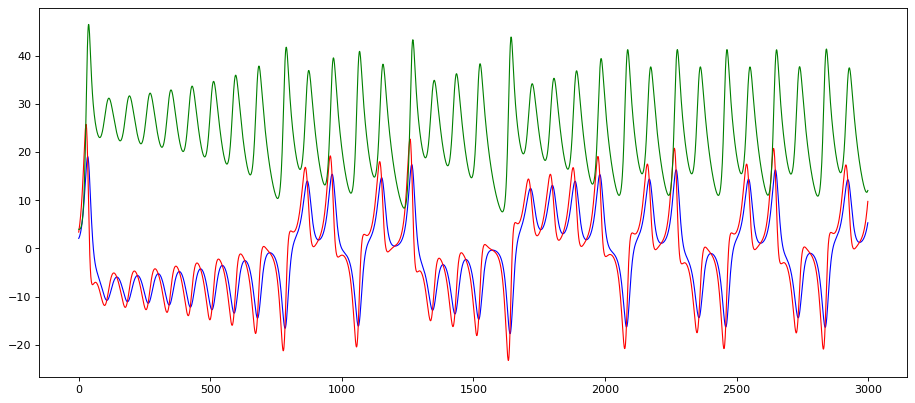

In [16]:
# 3D time series of healthy data

fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy)
#ax.set_ylim(0,energy.max())

ax.plot(range(0,size), data_healthy[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy[:,2], '-', color='green', animated = True, linewidth=1)

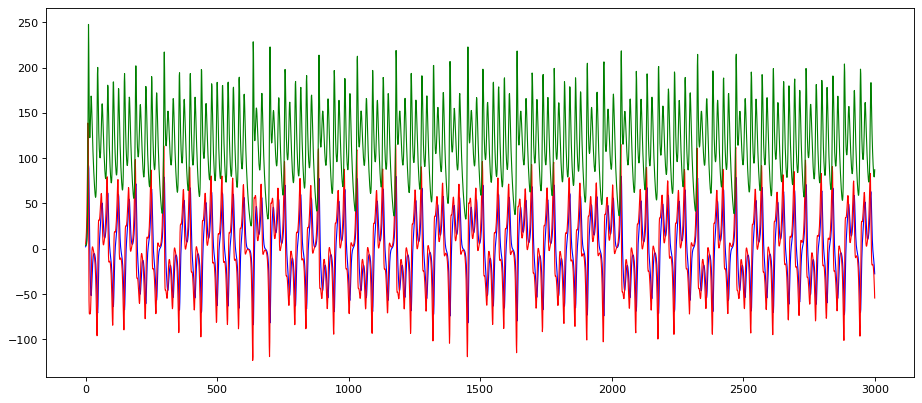

In [17]:
#  3D time series of broken data
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_broken)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_broken[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken[:,2], '-', color='green', animated = True, linewidth=1)

In [18]:
# prepare for frequency spectrum comparison by applying fft
import numpy as np
data_healthy_fft = np.fft.fft(data_healthy)
data_broken_fft = np.fft.fft(data_broken)

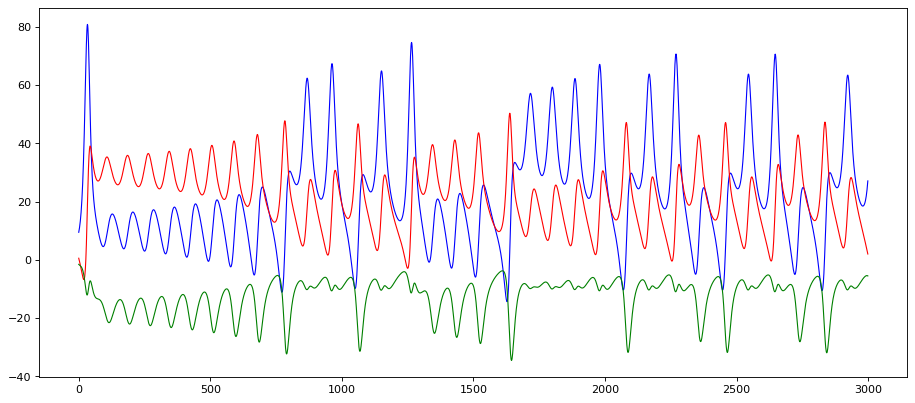

In [19]:
# plot frequency spectrum for healthy data

fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_healthy_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,1].imag, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,2].real, '-', color='green', animated = True, linewidth=1)

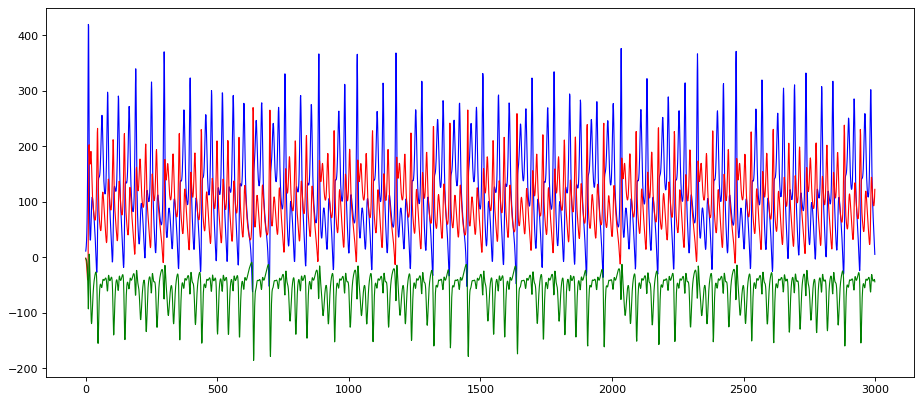

In [20]:
# plot frequency spectrum for broken data


fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_broken_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,1].imag, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,2].real, '-', color='green', animated = True, linewidth=1)

In [21]:
# convert test data from numpy to json (to be used when calling th web service via HTTP)

#data_healthy = data_healthy.tolist()
#data_healthy = json.dumps(data_healthy)
#data_broken = data_broken.tolist()
#data_broken = json.dumps(data_broken)

In [22]:
from flask import Flask

# Create a Flask application
app = Flask(__name__)

# Push the application context
app.app_context().push()

# Call the wrapper functions
send_data_wrapper(data_healthy)
reset_model_wrapper()




[[ 2.1836288   3.76812337  3.95194702]
 [ 2.31038837  4.18246112  3.9449437 ]
 [ 2.46015419  4.62243461  3.95176011]
 ...
 [ 4.38204584  8.00990112 11.66965424]
 [ 4.67227426  8.55622075 11.7405177 ]
 [ 4.98298998  9.13593768 11.85424761]]
Loss on_train_batch_end 15.301645278930664
Loss on_train_batch_end 15.418068885803223
Loss on_train_batch_end 14.962899208068848
Loss on_train_batch_end 15.163379669189453
Loss on_train_batch_end 14.641183853149414
Loss on_train_batch_end 14.926596641540527
Loss on_train_batch_end 14.661218643188477
Loss on_train_batch_end 14.61553955078125
Loss on_train_batch_end 14.711216926574707
Loss on_train_batch_end 14.432230949401855
Loss on_train_batch_end 14.646124839782715
Loss on_train_batch_end 14.445441246032715
Loss on_train_batch_end 14.41349983215332
Loss on_train_batch_end 14.494108200073242
Loss on_train_batch_end 14.244539260864258
Loss on_train_batch_end 14.418211936950684
Loss on_train_batch_end 14.2650785446167
Loss on_train_batch_end 14.126037

'done'